# Imports and Functions

In [1]:
import glob

#Numpy
import numpy as np
import scipy

#For image plotting
import skimage.io
import skimage.filters as sf
from skimage import io, measure, filters, transform, morphology

#Matplotlib plotting packages
import matplotlib.pyplot as plt

# For loading bars
from tqdm.notebook import tqdm as tqdm

import pandas as pd


Soichi's functions

In [2]:
def filter_mts(image, block_size=5, mask_size=5, yen=False):
    """
    Image processing for individual MT image file. Images are first normalized
    before applying local thresholding to correct for nonuniform image background.
    Global thresholding is then performed to obtain the thresholded image of
    putative microtubules. Further processing is performed where small breaks
    in filaments are reconnected again.
    """
    image_norm = (image - image.min()) / (image.max() - image.min())

    thresh_niblack = filters.threshold_niblack(image_norm, window_size=block_size,
                                                k=0.001)

    # Rather than applying the threshold to the image to create a binary
    # image, the threshold array thresh_niblack thickens the MTs, reducing
    # filament break-up. This is used then in the Otsu thresholding to
    # produce the binary image.
    thresh_otsu = filters.threshold_otsu(thresh_niblack)
    im_thresh = (thresh_niblack > thresh_otsu)

    mask = morphology.square(mask_size)
    im_closed = morphology.closing(im_thresh, selem=mask)

    if yen==True:
        im_subt = image - im_closed
        im_yen = filters.threshold_yen(im_subt)
        im_filtered = im_subt > im_yen
    else:
        im_filtered = im_closed.copy()

    return im_filtered

def border_clear(im_label, edge=3):
    """
    Remove objects within `edge` pixels from the image boundary

    Input
    -------
    im_label : labeled image where objects in the image are assigned positive integer value
    edge : maximum number of pixels that putative filament needs to be away from the image boundary to be rejected
    """
    im_border = np.copy(im_label)

    border = np.ones(np.shape(im_label))
    border[edge:-1*edge,edge:-1*edge] -= 1

    for n in np.unique(im_border):
        if np.any(border * [im_border==n+1]):
            im_border[im_border==n+1] = 0

    return im_border

def determine_count_nums(im_label):
    """
    Obtains maximum number of objects in the labeled image. Used to determine
    if background subtraction and thresholding must be performed on top of Niblack
    thresholding scheme.
    """
    unique, counts = np.unique(im_label, return_counts=True)

    return unique, counts

def remove_small(im_label, area_thresh=10):
    im_sized = np.copy(im_label)

    unique, counts = determine_count_nums(im_label)

    # Create dictionary except for 0 (background)
    dict_area = dict(zip(unique,counts))

    for label in unique:
        if label > 0 and dict_area[label]<=area_thresh:
            im_sized[im_sized==label] = 0
    
    return im_sized

def remove_circulars(im_label, eccen_thresh=0.8):
    im_eccen = im_label.copy()

    im_props = measure.regionprops_table(im_eccen,
                                        properties=['label','eccentricity'])
    df = pd.DataFrame(im_props)

    for n in np.unique(im_eccen):
        if df[df['label']==n]['eccentricity'].values < eccen_thresh:
            im_eccen[im_eccen==n] = 0

    return im_eccen

def are2lines(mt_segment, min_dist=9, min_angle=75):
    """
    Determine if putative microtubules are two microtubules. Uses
    Hough straight lines to determine if there are at least 2
    lines that can be drawn from the putative filament.
    
    Input
    -------
    mt_segment : (M, N), ndarray; cropped region about the putative
                 microtubule
    min_angle : int, minimum angle (in degrees) separating lines (default 75)
    
    Return
    -------
    len(angles)==2 : bool, determines whether there is a crossover
    """
    test_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
    h, theta, d = transform.hough_line(mt_segment, theta=test_angles)

    _, angles, _ = transform.hough_line_peaks(h, theta, d, 
                                                min_distance=min_dist,
                                                min_angle=min_angle,
                                                num_peaks=2)

    return len(angles)==2

def remove_line_crossovers(image, min_dist=9, min_angle=75, padding=3):
    """
    Removes microtubules that cross over in the images. 
    Input
    -------
    image : (M, N), ndarray; image from which MT crossovers are removed
    min_angle : int, minimum angle (in degrees) separating lines (default 30)
    padding : int, padding around cropped MT segments

    Return
    -------
    im_cleaned : (M, N), ndarray; image with MT crossovers removed
    """
    im_cleaned = image.copy()

    for n in np.unique(image)[1:]:
        x,y = np.where(image==n)
        mt_segment = image[x.min()-padding:x.max()+padding,y.min()-padding:y.max()+padding]
        
        if are2lines(mt_segment, min_dist=min_dist, min_angle=min_angle):
            im_cleaned = np.where(im_cleaned==n, 0, im_cleaned)

    return im_cleaned

def process_mt_images(image, block_size=3, mask_size=3, count_thresh=200, edge=3, area_thresh=10, min_dist=9, min_angle=75, padding=3):
    im_filtered = filter_mts(image, block_size=block_size, mask_size=mask_size)
    im_label, n_labels = measure.label(im_filtered, return_num=True)
    # Determine if Yen thresholding background subtraction is necessary
    unique, _ = determine_count_nums(im_label)
    if unique[-1] > count_thresh:
        im_filtered = filter_mts(image, block_size=block_size, mask_size=mask_size, yen=True)
        im_label, n_labels = measure.label(im_filtered, return_num=True)
    im_internal = border_clear(im_label, edge=edge)
    im_sized = remove_small(im_internal, area_thresh=area_thresh)
    im_thinned = morphology.thin(im_sized)
    im_relabel = measure.label(im_thinned)
    im_noxovers = remove_line_crossovers(im_relabel, min_dist=min_dist,
                                        min_angle=min_angle, padding=padding)

    return im_noxovers

My segmentation function

In [3]:
## Func for segmenting max proj

def segment(im, block_size=3, mask_size=1, edge=3, area_thresh=10, min_dist=9, min_angle=75, padding=3, plot=False):
    # #create the m=youaximum projection
    # proj = np.amax(stack-bg_avg, axis=0)
    
    #Normalize the image
    image_norm = (im - im.min()) / (im.max() - im.min())
    
    #Niblack thresholding - think like text
    thresh_niblack = filters.threshold_niblack(image_norm, window_size=block_size, k=0.001)
    
    #Otsu thresholding
    thresh_otsu = filters.threshold_otsu(thresh_niblack)
    im_thresh = (thresh_niblack > thresh_otsu)
    
    #Create a mask
    mask = morphology.square(mask_size)
    im_closed = morphology.closing(im_thresh, selem=mask)
    
    #Label each region
    im_filtered = im_closed.copy()
    im_label, n_labels = measure.label(im_filtered, return_num=True)
    unique_regions, region_counts = np.unique(im_label, return_counts=True)
    
    #Remove border
    im_border = np.copy(im_label)
    border = np.ones(np.shape(im_label))
    border[edge:-1*edge,edge:-1*edge] -= 1

    for n in np.unique(im_border):
        if np.any(border * [im_border==n+1]):
            im_border[im_border==n+1] = 0

    im_internal = im_border

    # Remove small regions - Create dictionary except for 0 (background)
    dict_area = dict(zip(unique_regions,region_counts))
    im_sized = np.copy(im_internal)
    for label in unique_regions:
        if label > 0 and dict_area[label]<=area_thresh:
            im_sized[im_sized==label] = 0
            
    #Thin each region - preserve connectivity but strip away any padding on the outside to get "skeleton"s
    im_thinned = morphology.thin(im_sized)
    im_relabel = measure.label(im_thinned)
    
    #Remove crossovers
    im_noxovers = remove_line_crossovers(im_relabel, min_dist=min_dist,
                                        min_angle=min_angle, padding=padding)
    
    #Determine properties
    im_props = measure.regionprops_table(im_noxovers, im,
                                    properties=['area', 'major_axis_length',
                                                'minor_axis_length','centroid',
                                                'orientation', 'eccentricity',
                                                'label', 'perimeter'])
    df = pd.DataFrame(im_props)
    
    if plot==True:
        fig, ax = plt.subplots(2,3)
        
        ax[0,0].imshow(image_norm)
        ax[0,0].set_title("Normalized")
        
        ax[0,1].imshow(im_thresh)
        ax[0,1].set_title("Thresholded")
        
        ax[0,2].imshow(im_label, vmin=0, vmax=1)
        ax[0,2].set_title("labeled")
        
        ax[1,0].imshow(im_sized, vmin=0, vmax=1)
        ax[1,0].set_title("Sized")
        
        ax[1,1].imshow(im_thinned, vmin=0, vmax=0.5)
        ax[1,1].set_title("Thinned")
        
        ax[1,2].imshow(im_noxovers, vmin=0, vmax=1)
        ax[1,2].set_title("No Crossover")
    
    return im_noxovers, df

## Import Images

Import the stack of interest and a camera off background image

In [4]:
#Import Stack
file_path = '../../data/gliding/'
file_folder = 'soichi_data/2023-Feb27NcdiLid_500uM_MT200_8/images/' #2023-03-24_Gliding/353/2023-Mar24_AnaGliding_Ncd-cherry-MT488_ATP353_lowATPload_2min_1/images/'
included_frames = '*2023*.tif'
im_dir = file_path+file_folder+included_frames

im_stack = []
files = np.sort(glob.glob(im_dir))
for file in files:
    im_stack.append(skimage.io.imread(file).astype(np.int16))
im_stack = np.array(im_stack)

frames = np.arange(len(im_stack))

#Import Background
bg_file_path = '../../data/gliding/'
bg_file_folder = '2023-Mar24_CAMERA-OFF_1/'
included_bg_frames = '2023-Mar24_CAMERA-OFF_1_MMStack_Pos0.ome.tif'
bg_im_dir = bg_file_path+bg_file_folder+included_bg_frames
bg_im = skimage.io.imread(im_dir).astype(np.int16)
bg_avg = np.average(bg_im)

## Check for anomalously bright pixels and remove

Check the maximum projection by eye, so long as everything is visible, it's fine. Otherwise need to remove something that is so bright it drowns out everything else

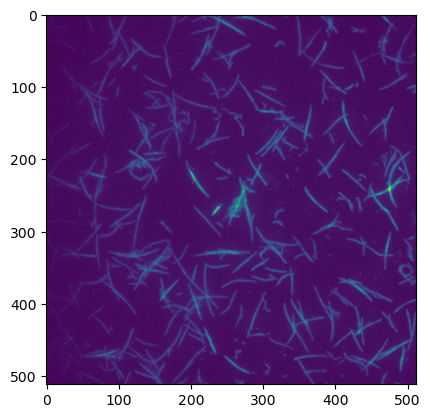

In [5]:
# Define a max projection
im_max = np.amax(im_stack, axis=0)
plt.imshow(im_max)

If something is too bright, Remove the frame with the brightest pixel. The following raw code cell works:

#Find the frame with the location of the brightest pixel
bright_frame = np.where(im_stack==im_max.max())[0][0]

#Exclude this frame
im_stack_rm = np.delete(im_stack, bright_frame, axis=0)

#Check the new max projection
im_max = np.amax(im_stack_rm, axis=0)
plt.imshow(im_max)

Create subsets of all the frames to do the max projection. Using all the r=frames can result in a very crowded image

In [6]:
#Define the number of frames you want to project over
proj_interval = 20

#Create an array of all the max proj
max_stack = []
for i in range(int(len(im_stack)/proj_interval)):
    proj = np.amax(im_stack[i*proj_interval:(i+1)*proj_interval], axis=0)
    max_stack.append(proj)
max_stack = np.array(max_stack)

## Define Properties

Here write the pixel to um conversion, as well as the thresholding parameters to be used

In [7]:
pixel_size = 0.161 #um/pixel

block_size=3
mask_size=1
edge=3
area_thresh=10
min_dist=9
min_angle=75
padding=3

# Process the Max Projection

Perform the segmentation for each image

In [8]:
# Create a list to save the processed images
max_proc_stack = []
#Create a list to store the dataframes
max_dfs = []

#loop through each projection
for i, im in enumerate(max_stack):
    im_max_processed, df_max = segment(im)
    max_proc_stack.append(im_max_processed)
    #Create a column to label the projection each row/MT comes from
    df_max['proj#'] = np.ones(len(df_max))*i
    max_dfs.append(df_max)

#Save a stack of the segmented projected images
max_proc_stack = np.array(max_proc_stack)
# Make a master list of all the datafames and reset the indices
df_max = pd.concat(max_dfs).reset_index()

Visualize each step of the thresholding

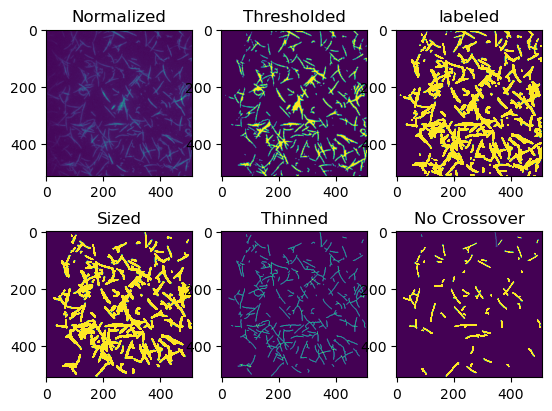

In [9]:
segment(im_max, plot=True);

Check DataFrame

In [10]:
df_max

,index,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,orientation,eccentricity,label,perimeter,proj#
0,0,31,36.138102,1.200973,19.000000,349.354839,0.141546,0.999448,1,30.656854,0.0
1,1,38,41.979048,6.956767,30.184211,470.657895,-0.393920,0.986173,2,41.213203,0.0
2,2,9,10.950093,1.174489,19.555556,426.000000,1.230042,0.994231,3,8.035534,0.0
3,3,9,14.145731,0.767893,25.000000,375.111111,-0.753695,0.998526,4,9.692388,0.0
4,4,8,8.474018,1.985198,42.375000,461.000000,0.029486,0.972172,5,6.828427,0.0
...,...,...,...,...,...,...,...,...,...,...,...
584,103,10,12.333316,1.284261,471.800000,94.500000,-1.196524,0.994564,143,9.242641,4.0
585,104,25,29.462378,1.813806,474.680000,355.000000,-1.365225,0.998103,144,25.071068,4.0
586,105,7,9.564858,1.117224,487.857143,95.571429,0.720079,0.993155,147,6.449747,4.0
587,106,18,23.311611,1.784964,491.444444,270.500000,1.096325,0.997064,148,19.313708,4.0


Print out the dataframe


## Generate Kymographs from max proj

### Visualize tracks

Function that takes the properties of a segmented region and finds the x and y vlaues of pixels corresponding to the major-axis line. This will be how we define tracks

In [11]:
def mt_track(xc, yc, l, theta):
    if theta>=np.pi:
        theta = theta-np.pi
    if np.abs(theta)<=np.pi/4:
        xvals = np.linspace(xc - np.abs(0.5*l*np.cos(theta)), xc + np.abs(0.5*l*np.cos(theta)))#.astype(int)
        yvals = (np.tan(theta)*xvals + (yc - np.tan(theta)*xc))#.astype(int)
    else:
        yvals = np.linspace(yc - np.abs(0.5*l*np.sin(theta)), yc + np.abs(0.5*l*np.sin(theta)))#.astype(int)
        xvals = (yvals/np.tan(theta) + (xc - yc/np.tan(theta)))#.astype(int)
    
    return xvals, yvals

Visualize a track on the image

## Compute speeds

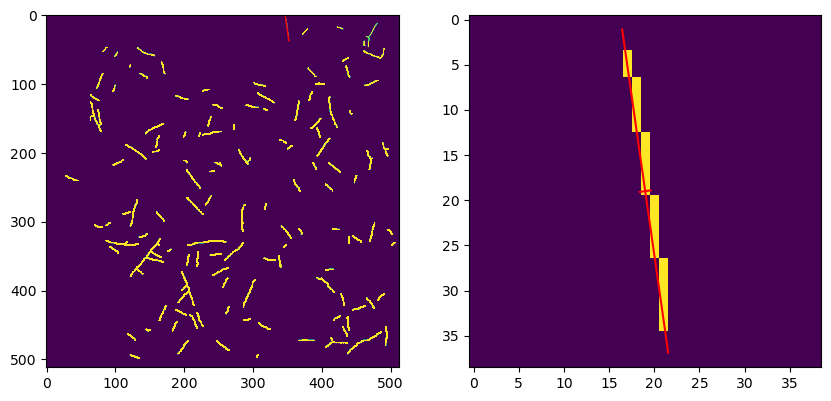

In [12]:
i = 0
proj_num = 0

# Calculate line
xc =  df_max[df_max['proj#']==proj_num].loc[i, 'centroid-1']
yc =  df_max[df_max['proj#']==proj_num].loc[i, 'centroid-0']
lmajor =  df_max[df_max['proj#']==proj_num].loc[i, 'major_axis_length']
lminor =  df_max[df_max['proj#']==proj_num].loc[i, 'minor_axis_length']
theta = -df_max[df_max['proj#']==proj_num].loc[i, 'orientation'] + (np.pi/2)

xmajor, ymajor = mt_track(xc, yc, lmajor, theta)
xminor, yminor = mt_track(xc, yc, lminor, theta-np.pi/2)

fig, ax = plt.subplots(1,2, figsize=(10,5))
#full frame
ax[0].imshow(max_proc_stack[proj_num], vmin=0, vmax=1)
ax[0].plot(xmajor, ymajor, color='r', lw=1)
#ax[0].scatter(xc, yc, color='r')

#Define crop
crop_win = int(lmajor/2+1)
cropmajx = xmajor-xc + crop_win #np.arange(crop_win - np.abs(0.5*l*np.cos(theta)), np.abs(crop_win + 0.5*l*np.cos(theta))).astype(int)
cropmajy = ymajor-yc + crop_win #(np.tan(theta)*(cropx) - 0.5*l*np.sin(theta))# - np.tan(theta)*(crop_win)).astype(int)
cropminx = xminor-xc + crop_win 
cropminy = yminor-yc + crop_win

ax[1].imshow(max_proc_stack[proj_num][int(yc-crop_win) : int(yc+crop_win+1), int(xc-crop_win) : int(xc+crop_win+1)], vmin=0, vmax=1)
ax[1].plot(cropmajx, cropmajy, color='r')
ax[1].plot(cropminx, cropminy, color='r')
#ax[1].scatter(crop_win,crop_win, color='red')

In [13]:
mykymo = []
for im in im_stack[0:proj_interval]:
    ls=[]
    for i in range(len(xmajor)):
        ls.append(im[int(ymajor[i]), int(xmajor[i])])
    mykymo.append(ls)
mykymo = np.array(mykymo)
kymo_func(mykymo, sigma = 2, pixel_size = pixel_size, plot=True)

NameError: name 'kymo_func' is not defined

### Calculate Speeds

In [13]:
def kymo_func(kymo, sigma, pixel_size, plot=False):
    
    #Create a gaussian blur
    gauss = sf.gaussian(kymo, sigma = sigma)

    #Threshold
    kymo_otsu = sf.threshold_otsu(gauss)
    im_thresh = gauss> kymo_otsu
    
    #Find the center of mass of each row
    row_coms = []
    for i, row_vals in enumerate(im_thresh):
        xdex = np.arange(len(row_vals))
        xcom = np.sum(row_vals*xdex)/np.sum(row_vals)
        row_coms.append(xcom)
    row_coms = np.array(row_coms)
    
    #Find if there are nans
    plot_frames = np.where(~np.isnan(row_coms))[0]
    
    #Fit a line
    mfit, bfit = np.polyfit(row_coms[plot_frames], plot_frames, deg=1)
    
    #Calculate the speed (nm/s)
    speed = 1000*pixel_size/np.abs(mfit)
    
    ss_res =  np.sum((plot_frames - (mfit*row_coms[plot_frames]+bfit))**2)
    ss_tot = np.sum((plot_frames - np.average(plot_frames))**2)
    rsqrd = 1-(ss_res/ss_tot)

    #Plot
    if plot==True:
        plt.imshow(kymo)
        plt.scatter(row_coms[plot_frames], plot_frames, color='k')
        plt.plot(xdex, mfit*xdex+bfit, color='r')
        plt.title(str(np.round(speed,1)) + ' nm/s')
        plt.ylim(0, len(kymo)-1)

    return speed, rsqrd, len(plot_frames)

In [14]:
speeds=[]
r2 = []
num_centr = []
count=0
for i in range(len(df_max)):
    xc =  df_max.loc[i, 'centroid-1']
    yc =  df_max.loc[i, 'centroid-0']
    l =  df_max.loc[i, 'major_axis_length']
    theta = -df_max.loc[i, 'orientation'] + (np.pi/2)
    
    xtrack, ytrack = mt_track(xc, yc, l, theta)
    
    mykymo = []

    for im in im_stack:
        ls=[]
        for i in range(len(xtrack)):
            ls.append(im[int(ytrack[i]), int(xtrack[i])])
        mykymo.append(ls)
    mykymo = np.array(mykymo)

    speed, rsqrd, num_centroids = kymo_func(mykymo, sigma = 1, pixel_size = pixel_size)
    speeds.append(speed)
    r2.append(rsqrd)
    num_centr.append(num_centroids)
    count+=1
speeds = np.array(speeds)
r2 = np.array(r2)
num_centr = np.array(num_centr)
df_max['speed (nm/s)'] = speeds
df_max['r^2'] = r2
df_max['num points'] = num_centr

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_54128/97330233.py:14: RuntimeWarning: invalid value encountered in long_scalars
  xcom = np.sum(row_vals*xdex)/np.sum(row_vals)


Sort the speeds and plot the ecdf

[Text(0, 0.0, '0.0'),
 Text(0, 0.25, '0.25'),
 Text(0, 0.5, '0.50'),
 Text(0, 0.75, '0.75'),
 Text(0, 1.0, '1.0')]

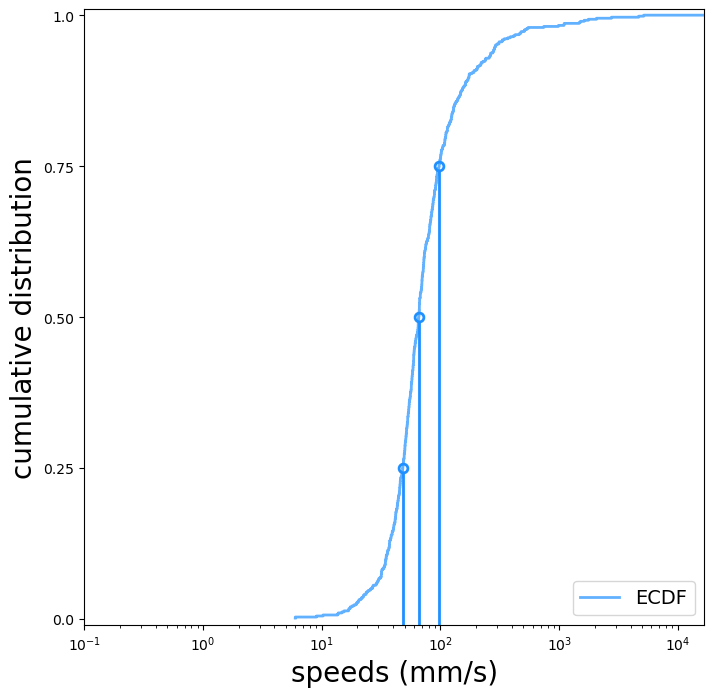

In [15]:
speedsort = np.sort(speeds)
ecdf = np.arange(1, len(speeds)+1, 1) /len(speeds)

q_25 = np.percentile(speedsort, 25)
q_50 = np.percentile(speedsort, 50)
q_75 = np.percentile(speedsort, 75)

fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.step(speedsort, ecdf, label='ECDF', color='dodgerblue', lw=2, zorder=4, alpha=0.7)

ax.scatter(q_25, 0.25, s=40, zorder=3, facecolor='w', edgecolor='dodgerblue', lw=2)
ax.scatter(q_50, 0.50, s=40, zorder=3, facecolor='w', edgecolor='dodgerblue', lw=2)
ax.scatter(q_75, 0.75, s=40, zorder=3, facecolor='w', edgecolor='dodgerblue', lw=2)

ax.axvline(q_25, 0, 0.25, color='dodgerblue', lw=2)
ax.axvline(q_50, 0, 0.50, color='dodgerblue', lw=2)
ax.axvline(q_75, 0, 0.75, color='dodgerblue', lw=2)

ax.set_xlim([0.1,np.max(speedsort)])
ax.set_ylim([-0.01,1.01])
ax.set_xlabel('speeds (mm/s)', fontsize=20)
ax.set_ylabel('cumulative distribution', fontsize=20)
ax.legend(fontsize=14, loc=4)
ax.set_xscale('log')

# ax.set_xticks([0.1, q_25, q_50, q_75, 10])
# ax.set_xticklabels(['0.1', '%.1f' %q_25, '%.1f' %q_50, '%.1f' %q_75, '10'])

ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0.0', '0.25', '0.50', '0.75', '1.0'])

# plt.savefig('../figures/SIFigX_MT_length_RB_manuscript.pdf', bbox_inches='tight',
#             facecolor='white')

In [16]:
np.average(speedsort)

156.12178671466054

Filter out rows that have too few points to fit or have a low r^2

In [17]:
df_good_ones = df_max[df_max['r^2']>0.8][df_max['num points']>20]
np.average(df_good_ones['speed (nm/s)'])

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_54128/1835664152.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_good_ones = df_max[df_max['r^2']>0.8][df_max['num points']>20]


73.11198621148267

In [18]:
len(df_good_ones)

379

[Text(0, 0.0, '0.0'),
 Text(0, 0.25, '0.25'),
 Text(0, 0.5, '0.50'),
 Text(0, 0.75, '0.75'),
 Text(0, 1.0, '1.0')]

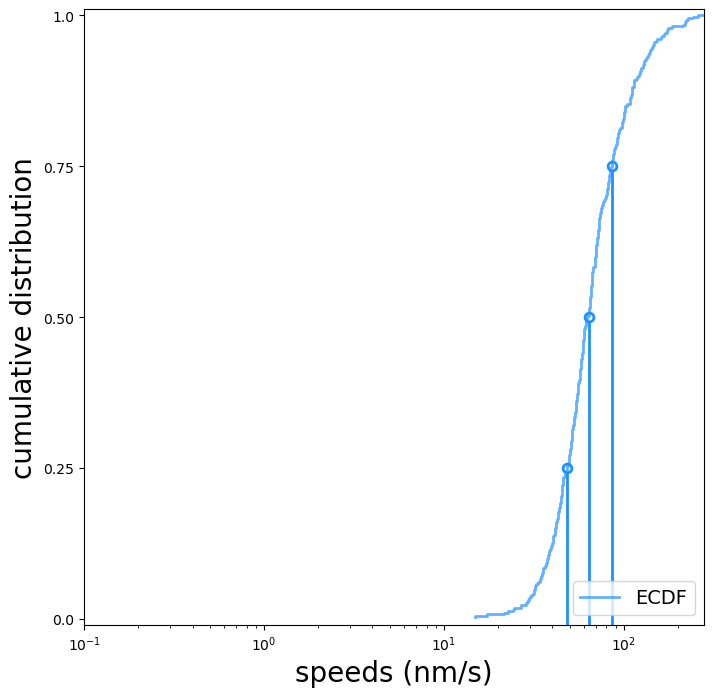

In [21]:
speedsort = np.sort(df_good_ones['speed (nm/s)'])
ecdf = np.arange(1, len(df_good_ones['speed (nm/s)'])+1, 1) /len(df_good_ones['speed (nm/s)'])

q_25 = np.percentile(speedsort, 25)
q_50 = np.percentile(speedsort, 50)
q_75 = np.percentile(speedsort, 75)

fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.step(speedsort, ecdf, label='ECDF', color='dodgerblue', lw=2, zorder=4, alpha=0.7)

ax.scatter(q_25, 0.25, s=40, zorder=3, facecolor='w', edgecolor='dodgerblue', lw=2)
ax.scatter(q_50, 0.50, s=40, zorder=3, facecolor='w', edgecolor='dodgerblue', lw=2)
ax.scatter(q_75, 0.75, s=40, zorder=3, facecolor='w', edgecolor='dodgerblue', lw=2)

ax.axvline(q_25, 0, 0.25, color='dodgerblue', lw=2)
ax.axvline(q_50, 0, 0.50, color='dodgerblue', lw=2)
ax.axvline(q_75, 0, 0.75, color='dodgerblue', lw=2)

ax.set_xlim([0.1,np.max(speedsort)])
ax.set_ylim([-0.01,1.01])
ax.set_xlabel('speeds (nm/s)', fontsize=20)
ax.set_ylabel('cumulative distribution', fontsize=20)
ax.legend(fontsize=14, loc=4)
ax.set_xscale('log')

# ax.set_xticks([0.1, q_25, q_50, q_75, 10])
# ax.set_xticklabels(['0.1', '%.1f' %q_25, '%.1f' %q_50, '%.1f' %q_75, '10'])

ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0.0', '0.25', '0.50', '0.75', '1.0'])

# plt.savefig('../figures/SIFigX_MT_length_RB_manuscript.pdf', bbox_inches='tight',
#             facecolor='white')

Plot the remaining tracks

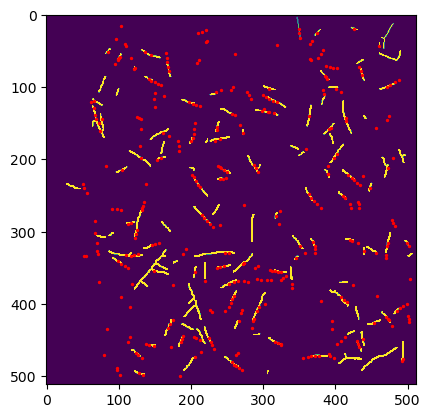

In [20]:
plt.imshow(max_proc_stack[0], vmin=0, vmax=1)
plt.scatter(df_good_ones['centroid-1'], df_good_ones['centroid-0'], s=2, color='r')

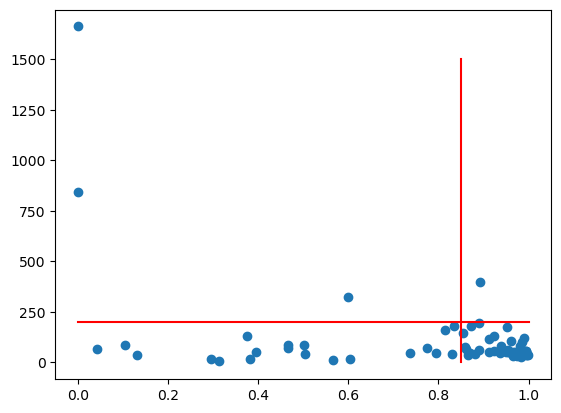

In [146]:
plt.scatter(df_max['r^2'], df_max['speed (nm/s)'])
plt.plot(np.linspace(0,1, 10), np.ones(10)*200, color='r')
plt.plot(np.ones(10)*0.85, np.linspace(0,1500, 10), color='r')

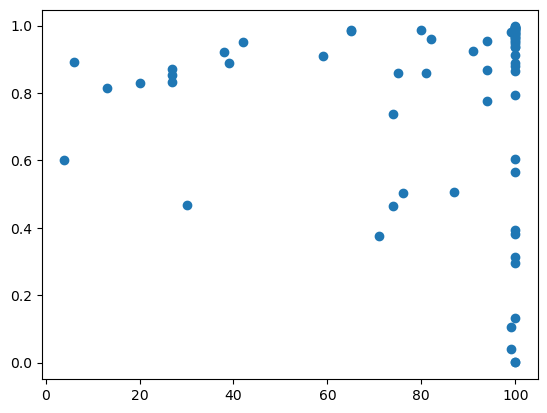

In [160]:
plt.scatter(df_max['num points'], df_max['r^2'])#df_max['speed (nm/s)'])
# plt.plot(np.linspace(0,1, 10), np.ones(10)*200, color='r')
# plt.plot(np.ones(10)*0.85, np.linspace(0,1500, 10), color='r')

### Make a Movie

### Process Kymographs

Create a kymograph

In [189]:
mykymo = []
for im in im_stack[start:stop]:
    ls=[]
    for i in range(len(xmajor)):
        ls.append(im[int(ymajor[i]), int(xmajor[i])])
    mykymo.append(ls)
mykymo = np.array(mykymo)
kymo_func(mykymo, sigma = 2, pixel_size = pixel_size, plot=True)

Defines a function for fitting a kymograph

Plot the kymograph

(152.34869911875782, 0.9467373949408211, 20)

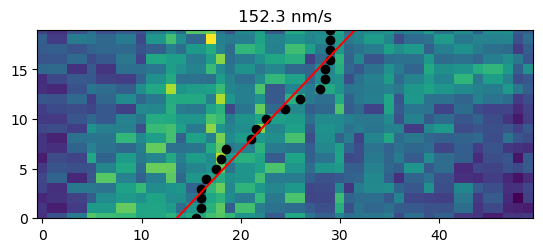

In [191]:
kymo_func(mykymo, sigma = 2, pixel_size = pixel_size, plot=True)

(0.0, 19.0)

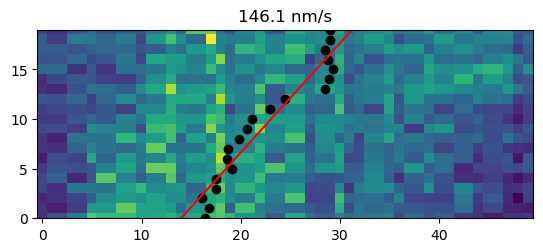

In [192]:
#Create a gaussian blur
gauss = sf.gaussian(mykymo, sigma = 1)

#Threshold
kymo_otsu = sf.threshold_otsu(gauss)
im_thresh = gauss> kymo_otsu

#Find the center of mass of each row
row_coms = []
for i, row_vals in enumerate(im_thresh):
    xdex = np.arange(len(row_vals))
    xcom = np.sum(row_vals*xdex)/np.sum(row_vals)
    row_coms.append(xcom)
row_coms = np.array(row_coms)

#Find if there are nans
plot_frames = np.where(~np.isnan(row_coms))[0]

#Fit a line
mfit, bfit = np.polyfit(row_coms[plot_frames], plot_frames, deg=1)

#Calculate the speed (nm/s)
speed = 1000*pixel_size/np.abs(mfit)

#Plot
plt.imshow(mykymo)
plt.scatter(row_coms[plot_frames], plot_frames, color='k')
plt.plot(xdex, mfit*xdex+bfit, color='r')
plt.title(str(np.round(speed,1)) + ' nm/s')
plt.ylim(0, len(mykymo)-1)

Calculate r^2

In [193]:
ss_res =  np.sum((plot_frames - (mfit*row_coms[plot_frames]+bfit))**2)
ss_tot = np.sum((plot_frames - np.average(plot_frames))**2)
1-(ss_res/ss_tot)

0.9161518904597936

## Process single frame

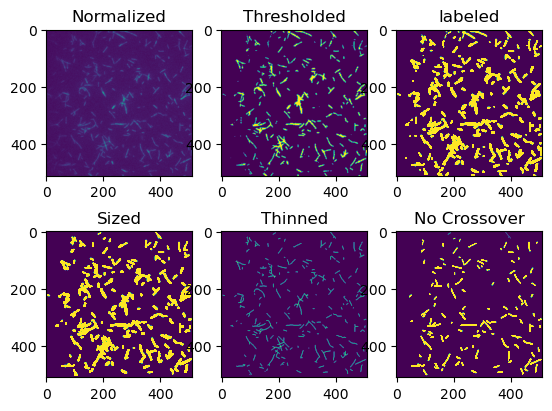

In [52]:
im_last_processed, df_last = segment(im_stack[-1], plot=True)

In [53]:
df_last

,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,orientation,eccentricity,label,perimeter
0,28,33.142167,4.338350,15.285714,392.857143,0.666705,0.991395,1,32.041631
1,10,13.860755,0.916228,8.300000,186.500000,-0.975651,0.997813,2,10.278175
2,7,8.501496,0.931359,26.000000,204.000000,-1.223427,0.993981,5,5.828427
3,9,10.948084,1.014079,32.000000,223.333333,-0.339707,0.995701,6,8.035534
4,21,21.903168,4.731041,38.523810,93.904762,-0.155683,0.976394,7,21.692388
...,...,...,...,...,...,...,...,...,...
120,10,12.708531,1.527491,487.000000,456.600000,1.028012,0.992750,158,9.656854
121,5,7.279216,0.879216,490.000000,98.200000,0.686700,0.992679,159,4.035534
122,16,20.540330,1.237875,492.687500,272.500000,1.113631,0.998182,160,16.899495
123,16,18.518290,1.005196,494.437500,365.500000,-1.478139,0.998526,162,14.414214


## Compare Single Frame with Max Proj

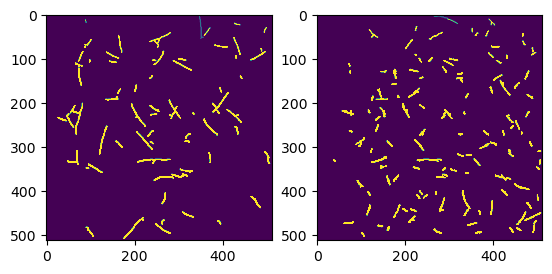

In [54]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_max_processed, vmin=0, vmax=1)
ax[1].imshow(process_mt_images(im_stack[-1]), vmin=0, vmax=1)

In [55]:
track_frac = np.zeros(len(np.unique(im_max_processed)))
for i, val in enumerate(np.unique(im_max_processed)[1:]):
    frame_vals = im_last_processed[np.where(im_max_processed==val)]
    
    if len(np.unique(frame_vals)) > 2:
        print(i, val, np.unique((frame_vals)))
    else:
        frac = len(np.nonzero(frame_vals)) / len(frame_vals)
        track_frac[i+1] += frac
track_frac = track_frac[1:]

41 64 [ 0 77 92]


In [56]:
track_frac

array([0.01785714, 0.125     , 0.07142857, 0.05555556, 0.08333333,
       0.01369863, 0.02564103, 0.02564103, 0.06666667, 0.11111111,
       0.03448276, 0.16666667, 0.03030303, 0.04347826, 0.02941176,
       0.03571429, 0.16666667, 0.05882353, 0.16666667, 0.14285714,
       0.02380952, 0.0625    , 0.05263158, 0.02631579, 0.125     ,
       0.16666667, 0.06666667, 0.08333333, 0.1       , 0.01515152,
       0.03125   , 0.01470588, 0.00961538, 0.01851852, 0.04166667,
       0.02380952, 0.25      , 0.03125   , 0.07142857, 0.05      ,
       0.02631579, 0.        , 0.05263158, 0.06666667, 0.02439024,
       0.07142857, 0.09090909, 0.0625    , 0.125     , 0.03333333,
       0.03571429, 0.04347826, 0.01234568, 0.05263158, 0.03125   ,
       0.16666667, 0.03571429, 0.025     , 0.02272727, 0.04      ,
       0.03448276, 0.04      , 0.01851852, 0.09090909, 0.11111111,
       0.03030303, 0.04166667])

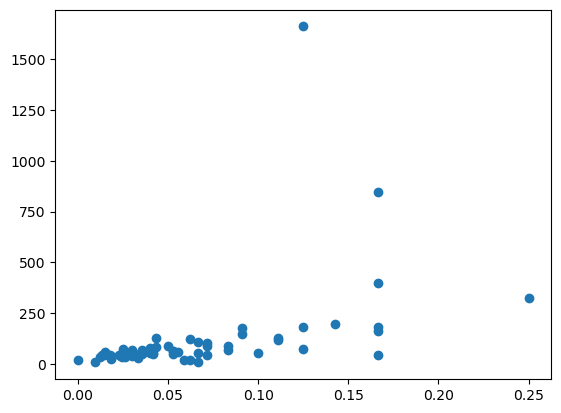

In [58]:
plt.scatter(track_frac, speeds)


# Try Single frame tracking rather than kymograph

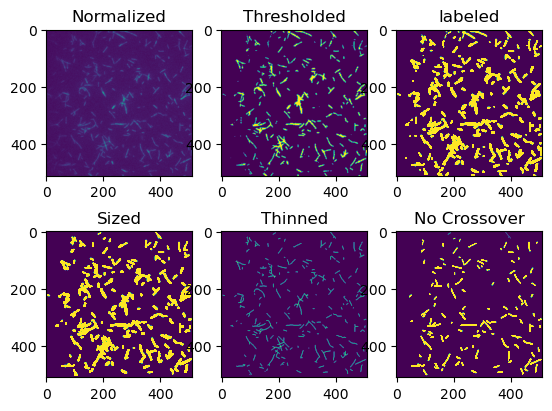

In [23]:
im_last_processed, df_last = segment(im_stack[-1], plot=True)

In [24]:
df_template =pd.DataFrame.copy(df_max)
frame_template = np.zeros(len(df_max['label']))+np.inf

df_template['frame'] = frame_template

df_template

,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,orientation,eccentricity,label,perimeter,frame
0,56,62.578292,3.770626,31.107143,350.339286,0.091006,0.998183,1,55.485281,inf
1,8,9.507915,1.161702,15.500000,89.625000,0.271413,0.992508,2,6.621320,inf
2,14,16.147344,1.783720,22.500000,432.571429,1.330964,0.993880,4,13.242641,inf
3,18,25.814831,1.049132,39.500000,364.555556,-0.637587,0.999174,5,20.970563,inf
4,12,14.620444,1.737925,35.583333,495.833333,-0.429455,0.992910,6,11.656854,inf
...,...,...,...,...,...,...,...,...,...,...
62,54,77.355268,3.873602,483.111111,198.203704,-0.731169,0.998745,106,67.154329,inf
63,11,12.451499,3.440379,470.272727,263.636364,-0.472697,0.961071,107,10.449747,inf
64,9,12.621997,1.631104,471.111111,392.555556,0.701787,0.991615,108,9.071068,inf
65,33,46.054476,2.640177,486.696970,264.000000,0.972652,0.998355,109,39.698485,inf


In [25]:
df_stack = pd.DataFrame.copy(df_template)

for i, im in enumerate(tqdm(im_stack)):    
    demi_im, demi_df = segment(im)
    demi_df['frame'] = np.ones(len(demi_df['label']))*frames[i]
    df_stack = pd.concat([df_stack, demi_df])
df_stack = df_stack[df_stack['frame'] != np.inf]

  0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
df_stack

,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,orientation,eccentricity,label,perimeter,frame
0,35,40.341493,5.759170,26.971429,471.800000,-0.481880,0.989757,2,37.213203,0.0
1,64,56.786429,7.021226,40.875000,224.984375,-0.416597,0.992327,3,69.562446,0.0
2,5,5.656854,0.000000,43.000000,317.000000,1.570796,1.000000,4,3.000000,0.0
3,6,8.652106,0.834637,50.500000,84.833333,-0.664362,0.995336,5,5.242641,0.0
4,23,27.720618,2.866642,56.391304,147.043478,1.242417,0.994639,6,23.899495,0.0
...,...,...,...,...,...,...,...,...,...,...
120,10,12.708531,1.527491,487.000000,456.600000,1.028012,0.992750,158,9.656854,99.0
121,5,7.279216,0.879216,490.000000,98.200000,0.686700,0.992679,159,4.035534,99.0
122,16,20.540330,1.237875,492.687500,272.500000,1.113631,0.998182,160,16.899495,99.0
123,16,18.518290,1.005196,494.437500,365.500000,-1.478139,0.998526,162,14.414214,99.0


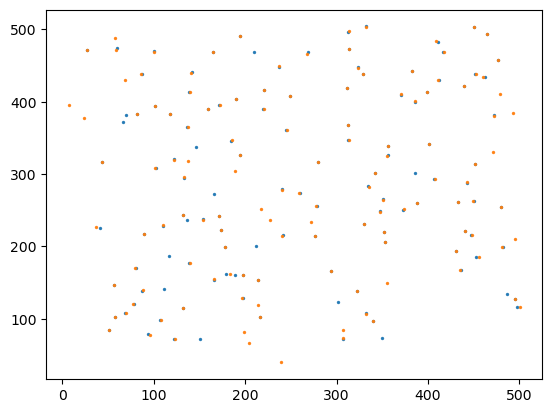

In [36]:
plt.scatter(df_stack[df_stack['frame']==0]['centroid-0'], df_stack[df_stack['frame']==0]['centroid-1'], alpha=0.9, s=2)
plt.scatter(df_stack[df_stack['frame']==1]['centroid-0'], df_stack[df_stack['frame']==1]['centroid-1'], alpha=0.9, s=2)

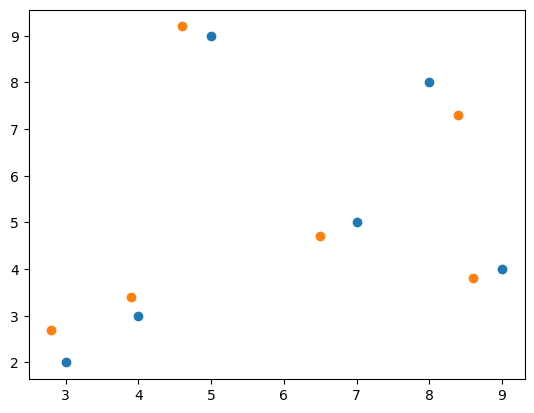

In [51]:
testxc0 = np.array([3, 7, 4, 8, 5, 9])
testyc0 = np.array([2, 5, 3, 8, 9, 4])
testxc1 = np.array([2.8, 6.5, 3.9, 8.4, 4.6, 8.6])
testyc1 = np.array([2.7, 4.7, 3.4, 7.3, 9.2, 3.8])
plt.scatter(testxc0, testyc0)
plt.scatter(testxc1, testyc1)

In [42]:
box_speed_size = int((200/pixel_size/1000)+1)
box_speed_size

2

(70.0, 74.0)

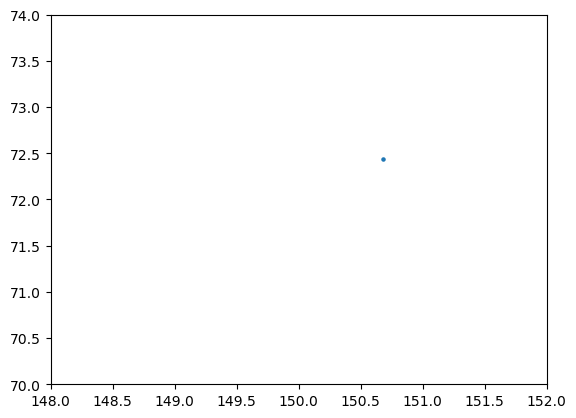

In [48]:
plt.scatter(df_stack[df_stack['frame']==0]['centroid-0'], df_stack[df_stack['frame']==0]['centroid-1'], s=5)
plt.scatter(df_stack[df_stack['frame']==1]['centroid-0'], df_stack[df_stack['frame']==1]['centroid-1'], s=5)
plt.xlim(int(df_stack[df_stack['frame']==0]['centroid-0'][30]-box_speed_size), int(df_stack[df_stack['frame']==0]['centroid-0'][30]+box_speed_size))
plt.ylim(int(df_stack[df_stack['frame']==0]['centroid-1'][30]-box_speed_size), int(df_stack[df_stack['frame']==0]['centroid-1'][30]+box_speed_size))

In [39]:
len(df_stack[df_stack['frame']==0])

127

In [27]:
len(df_stack[df_stack['frame']==7])

138

In [54]:
test = np.chararray(67, itemsize=10)
test[:] = 'max_proj'
test

chararray([b'max_proj', b'max_proj', b'max_proj', b'max_proj',
           b'max_proj', b'max_proj', b'max_proj', b'max_proj',
           b'max_proj', b'max_proj', b'max_proj', b'max_proj',
           b'max_proj', b'max_proj', b'max_proj', b'max_proj',
           b'max_proj', b'max_proj', b'max_proj', b'max_proj',
           b'max_proj', b'max_proj', b'max_proj', b'max_proj',
           b'max_proj', b'max_proj', b'max_proj', b'max_proj',
           b'max_proj', b'max_proj', b'max_proj', b'max_proj',
           b'max_proj', b'max_proj', b'max_proj', b'max_proj',
           b'max_proj', b'max_proj', b'max_proj', b'max_proj',
           b'max_proj', b'max_proj', b'max_proj', b'max_proj',
           b'max_proj', b'max_proj', b'max_proj', b'max_proj',
           b'max_proj', b'max_proj', b'max_proj', b'max_proj',
           b'max_proj', b'max_proj', b'max_proj', b'max_proj',
           b'max_proj', b'max_proj', b'max_proj', b'max_proj',
           b'max_proj', b'max_proj', b'max_proj', b'max

In [55]:
len(df_all['label'])

67

# 1410 Try it 

In [202]:
pixel_size = 0.161 #um/pixel

#Import Stack
file_path = '../../data/gliding/'
file_folder = '2023-03-23_Gliding/2023-Mar23_AnaGliding_Ncd-cherry-freshMT488_lowATPload_min_2/images/'
included_frames = '*2023*.tif'
im_dir = file_path+file_folder+included_frames

im_stack = []
files = np.sort(glob.glob(im_dir))
for file in files:
    im_stack.append(skimage.io.imread(file).astype(np.int16))
im_stack = np.array(im_stack)

#Import Background
bg_file_path = '../../data/gliding/'
bg_file_folder = '2023-Mar24_CAMERA-OFF_1/'
included_bg_frames = '2023-Mar24_CAMERA-OFF_1_MMStack_Pos0.ome.tif'
bg_im_dir = bg_file_path+bg_file_folder+included_bg_frames
bg_im = skimage.io.imread(im_dir).astype(np.int16)
bg_avg = np.average(bg_im)

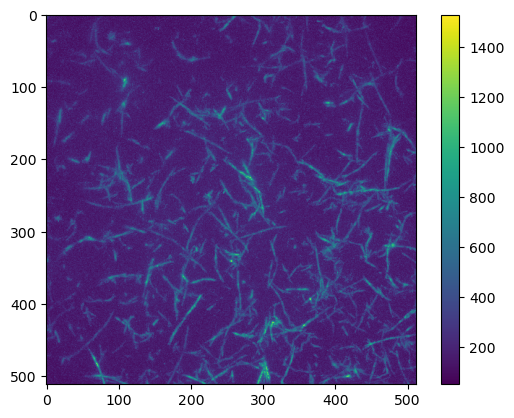

In [203]:
#Create a maximum projection image -- create a single image where each pixel value is the maximum intensity for that pixel across all images in the stack
max_proj = np.amax(im_stack-bg_avg, axis=0)
plt.imshow(max_proj)
plt.colorbar()

# - end - 

In [21]:
bg_file_path = '../../data/gliding/'
bg_file_folder = '2023-Mar24_CAMERA-OFF_1/'
included_bg_frames = '2023-Mar24_CAMERA-OFF_1_MMStack_Pos0.ome.tif'
bg_im_dir = bg_file_path+bg_file_folder+included_bg_frames
bg_im = skimage.io.imread(im_dir).astype(np.int16)
bg_avg = np.average(bg_im)

In [4]:
#Import stack
file_path = '../../data/gliding/'
file_folder = '2023-03-24_Gliding/940/2023-Mar24_AnaGliding_Ncd-cherry-MT488_ATP940_lowATPload_4.5min_1/images/'
included_frames = '*2023*.tif'
im_dir = file_path+file_folder+included_frames

im_stack = []
files = np.sort(glob.glob(im_dir))
for file in files:
    im_stack.append(skimage.io.imread(file).astype(np.int16))
im_stack = np.array(im_stack)

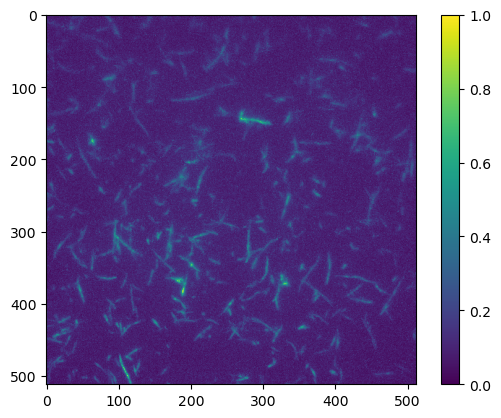

In [16]:
#Choose the experiment file name(located in folder 'Asters'):
file_path = '../../data/gliding/'
file_folder = '2023-03-24_Gliding/940/2023-Mar24_AnaGliding_Ncd-cherry-MT488_ATP940_lowATPload_4.5min_1/'
included_frames = 'MAX_2023-Mar24_AnaGliding_Ncd-cherry-MT488_ATP940_lowATPload_4.5min_1_MMStack_Pos0.ome.tif'
im_dir = file_path+file_folder+included_frames
max_proj = skimage.io.imread(im_dir).astype(np.int16)
max_proj_norm = (max_proj - max_proj.min()) / (max_proj.max() - max_proj.min())
plt.imshow(max_proj_norm)
plt.colorbar()

# Single Kymograph Analysis

In [64]:
def kymo_func(im_dir, bg_im_dir, sigma, mask_size, pixel_size):

    #Read in images
    kymo = skimage.io.imread(im_dir).astype(np.int16)
    bg = skimage.io.imread(bg_im_dir).astype(np.int16)
    
    #Subtract camera noise
    bg_avg = np.average(bg)
    kymo_bs = kymo - bg_avg
    
    #Create a gaussian blur
    gauss = sf.gaussian(kymo_bs, sigma = sigma)

    #Threshold
    kymo_otsu = sf.threshold_otsu(gauss)
    im_thresh = gauss> kymo_otsu

    #Mask/Block
    mask_size=mask_size
    mask = morphology.square(mask_size)
    im_closed = morphology.closing(im_thresh, selem=mask)

    #Extract properties
    im_relabel = measure.label(im_closed)
    im_props = measure.regionprops_table(im_relabel, kymo,
                                        properties=['area', 'major_axis_length',
                                                    'minor_axis_length','centroid',
                                                    'orientation', 'eccentricity',
                                                    'label', 'perimeter'])
    _df = pd.DataFrame(im_props)
    df_mt = _df.loc[_df['area'] == np.max(_df['area'])].reset_index()

    # Create test line
    xvals = np.arange(0, np.shape(kymo)[1])
    index = 0
    xc =  df_mt.loc[index, 'centroid-1']
    yc =  df_mt.loc[index, 'centroid-0']
    l =  df_mt.loc[index, 'major_axis_length']
    theta = -df_mt.loc[index, 'orientation'] + (np.pi/2)

    test_line = np.tan(theta)*xvals + (yc - np.tan(theta)*xc)


#     fig, ax  = plt.subplots(1,4, figsize = (8,8))

#     ax[0].imshow(kymo_bs)
#     ax[0].plot(xvals, test_line, color='r')
#     ax[0].scatter(xc, yc, color = 'r')

#     ax[1].imshow(gauss)
#     ax[1].plot(xvals, test_line, color='r')
#     ax[1].scatter(xc, yc, color = 'r')

#     ax[2].imshow(im_thresh)
#     ax[2].plot(xvals, test_line, color='r')
#     ax[2].scatter(xc, yc, color = 'r')

#     ax[3].imshow(im_closed)
#     ax[3].plot(xvals, test_line, color='r')
#     ax[3].scatter(xc, yc, color = 'r')

    return np.abs(pixel_size / np.tan(theta))*1000 #nm/s

In [294]:
#Choose the experiment file name(located in folder 'Asters'):
file_path = '../../data/gliding/'
file_folder = '2023-03-24_Gliding/940/2023-Mar24_AnaGliding_Ncd-cherry-MT488_ATP940_lowATPload_4.5min_1/kymo/'
included_frames = 'W44H1X350Y178.tif'
im_dir = file_path+file_folder+included_frames

bg_file_path = '../../data/gliding/'
bg_file_folder = '2023-Mar24_CAMERA-OFF_1/'
included_bg_frames = '2023-Mar24_CAMERA-OFF_1_MMStack_Pos0.ome.tif'
bg_im_dir = bg_file_path+bg_file_folder+included_bg_frames

pixel_size = pixel_size = 0.161 # µm per pixel

kymo_func(im_dir, bg_im_dir, sigma = 1, mask_size=3, pixel_size = pixel_size)

TypeError: kymo_func() got multiple values for argument 'sigma'

## Test im

In [221]:
def kymo_func(kymo, sigma, mask_size, pixel_size):

    #Create a gaussian blur
    gauss = sf.gaussian(kymo, sigma = sigma)

    #Threshold
    kymo_otsu = sf.threshold_otsu(gauss)
    im_thresh = gauss> kymo_otsu

    #Mask/Block
    mask_size=mask_size
    mask = morphology.square(mask_size)
    im_closed = morphology.closing(im_thresh, selem=mask)

    #Extract properties
    im_relabel = measure.label(im_closed)
    im_props = measure.regionprops_table(im_relabel, kymo,
                                        properties=['area', 'major_axis_length',
                                                    'minor_axis_length','centroid',
                                                    'orientation', 'eccentricity',
                                                    'label', 'perimeter'])
    _df = pd.DataFrame(im_props)
    df_mt = _df.loc[_df['area'] == np.max(_df['area'])].reset_index()

    # Create test line
    xvals = np.arange(0, np.shape(kymo)[1])
    index = 0
    xc =  df_mt.loc[index, 'centroid-1']
    yc =  df_mt.loc[index, 'centroid-0']
    l =  df_mt.loc[index, 'major_axis_length']
    theta = -df_mt.loc[index, 'orientation'] + (np.pi/2)

    test_line = np.tan(theta)*xvals + (yc - np.tan(theta)*xc)


    fig, ax  = plt.subplots(4, figsize = (8,3))

    ax[0].imshow(kymo)
    ax[0].plot(xvals, test_line, color='r')
    ax[0].scatter(xc, yc, color = 'r')

    ax[1].imshow(gauss)
    ax[1].plot(xvals, test_line, color='r')
    ax[1].scatter(xc, yc, color = 'r')

    ax[2].imshow(im_thresh)
    ax[2].plot(xvals, test_line, color='r')
    ax[2].scatter(xc, yc, color = 'r')

    ax[3].imshow(im_closed)
    ax[3].plot(xvals, test_line, color='r')
    ax[3].scatter(xc, yc, color = 'r')

    print(str(np.abs(pixel_size / np.tan(theta))*1000) + ' nm/s')

4307.4051923649795 nm/s


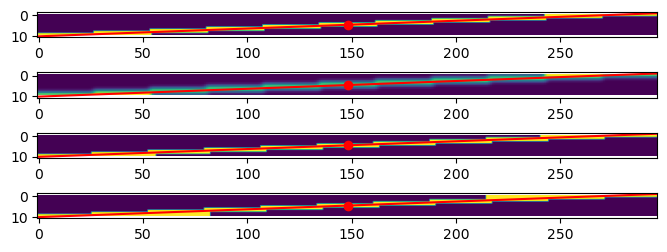

In [104]:
#Choose the experiment file name(located in folder 'Asters'):
file_path = '../../data/gliding/'
file_folder = 'kymo-example/'
included_frames = 'multikymo.tif'
im_dir = file_path+file_folder+included_frames

pixel_size = pixel_size = 0.161 # µm per pixel

kymo_func(im_dir, sigma = 1, mask_size=3, pixel_size = pixel_size)

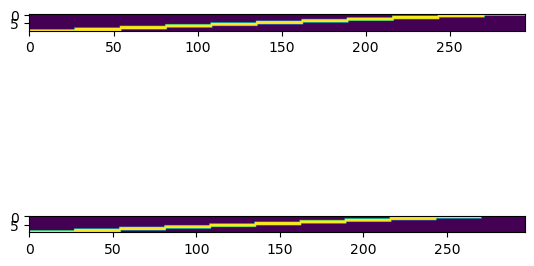

In [106]:
#compare fiji kymos:
#kymo builder plugin
#Choose the experiment file name:
file_path = '../../data/gliding/'
file_folder = 'kymo-example/'
included_frames = 'kymobuilder.tif'
im_dir = file_path+file_folder+included_frames
kymobuild = skimage.io.imread(im_dir).astype(np.int16)

#multi kymo
#Choose the experiment file name:
file_path = '../../data/gliding/'
file_folder = 'kymo-example/'
included_frames = 'multikymo.tif'
im_dir = file_path+file_folder+included_frames
multikymo = skimage.io.imread(im_dir).astype(np.int16)

fig,ax=plt.subplots(2)
ax[0].imshow(kymobuild)
ax[1].imshow(multikymo)

In [116]:
np.unique(multikymo[:,1:-1])

array([  0, 255], dtype=int16)

In [115]:
np.where((multikymo[:,1:-1]==kymobuild) == False)

(array([0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9]),
 array([242, 215, 270, 188, 243, 161, 216, 134, 189, 107, 162,  80, 135,
         53, 108,  26,  81,  54]))

In [117]:
np.unique(kymobuild)

array([  0, 255], dtype=int16)

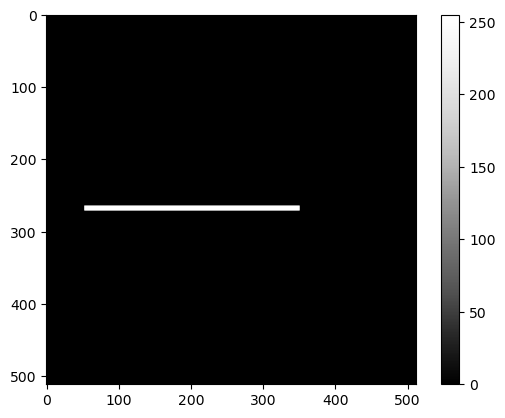

In [118]:
#Import the Max Proj

#Choose the experiment file name:
file_path = '../../data/gliding/'
file_folder = 'kymo-example/'
included_frames = 'MAX_kymo-exstack.tif'
im_dir = file_path+file_folder+included_frames
max_proj = skimage.io.imread(im_dir).astype(np.int16)

plt.imshow(max_proj, cmap = 'Greys_r')
plt.colorbar()

In [119]:
np.unique(max_proj)

array([  0, 255], dtype=int16)

In [59]:
np.where(max_proj==255)

(array([265, 265, 265, ..., 271, 271, 271]),
 array([ 53,  54,  55, ..., 348, 349, 350]))

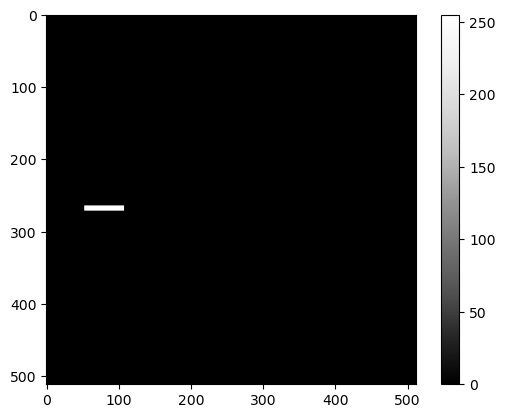

In [200]:
#Import stack of image
#Choose the experiment file name:
file_path = '../../data/gliding/'
file_folder = 'kymo-example/images/'
included_frames = '*images*.tif'
im_dir = file_path+file_folder+included_frames
stack = []
files = np.sort(glob.glob(im_dir))
for file in files:
    stack.append(skimage.io.imread(file).astype(np.int16))
stack = np.array(stack)

plt.imshow(stack[0], cmap='Greys_r')
plt.colorbar()

In [201]:
stack_norm = []
for im in stack:
    norm = (im - im.min()) / (im.max() - im.min())
    stack_norm.append(norm)
stack_norm = np.array(stack_norm)

In [202]:
np.unique(np.sum(stack_norm, axis=0))

array([0., 1., 2., 3.])

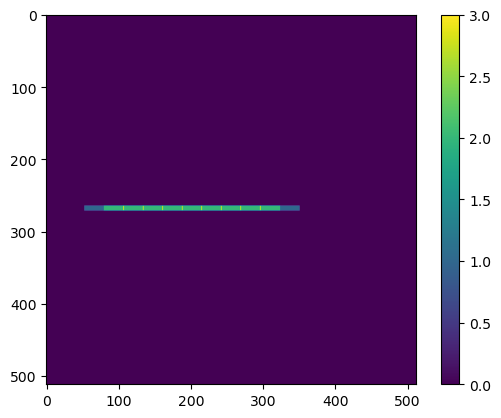

In [203]:
#make max_proj
max_im = np.sum(stack_norm, axis=0)
plt.imshow(max_im, vmin=0, vmax=3)
plt.colorbar()

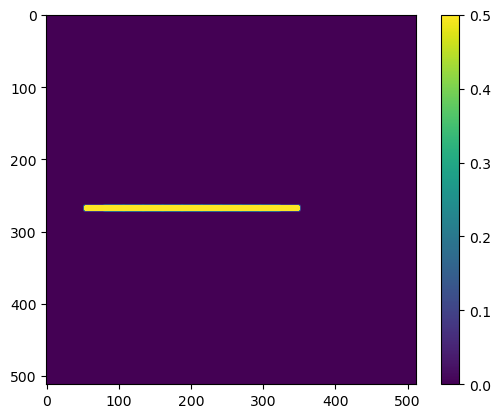

In [204]:
block_size = 3
thresh_niblack = filters.threshold_niblack(max_im, window_size=block_size, k=0.001)
plt.imshow(thresh_niblack, vmin=0, vmax=0.5)
plt.colorbar()

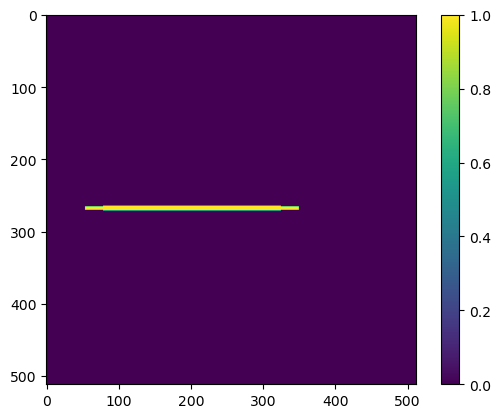

In [205]:
thresh_otsu = filters.threshold_otsu(thresh_niblack)
im_thresh = (thresh_niblack > thresh_otsu)
plt.imshow(im_thresh)
plt.colorbar()

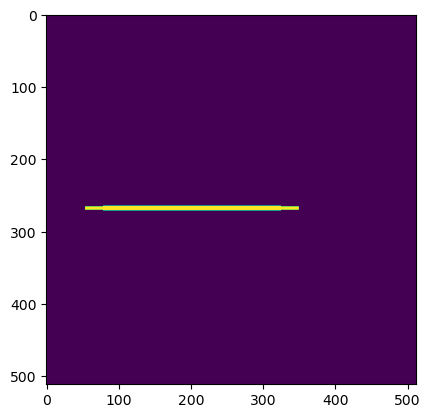

In [206]:
mask_size=1
mask = morphology.square(mask_size)
im_closed = morphology.closing(im_thresh, selem=mask)
plt.imshow(im_closed)

number of regions = 1


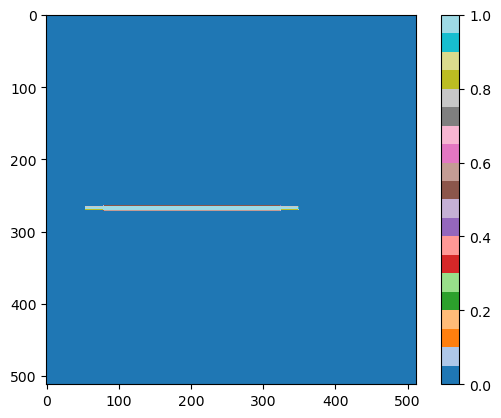

In [207]:
im_filtered = im_closed.copy()
im_label, n_labels = measure.label(im_filtered, return_num=True)
print('number of regions = ' + str(n_labels))
plt.imshow(im_label, cmap = 'tab20')
plt.colorbar();

In [208]:
unique_regions, region_counts = np.unique(im_label, return_counts=True)
# Create dictionary except for 0 (background)
dict_area = dict(zip(unique_regions,region_counts))

#Remove small regions
area_thresh=10
im_sized = np.copy(im_label)
for label in unique_regions:
    if label > 0 and dict_area[label]<=area_thresh:
        im_sized[im_sized==label] = 0

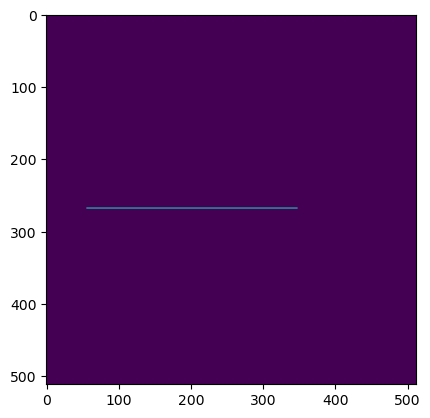

In [209]:
im_thinned = morphology.thin(im_sized)
im_relabel = measure.label(im_thinned)
plt.imshow(im_thinned)

In [210]:
min_dist=9
min_angle=75
padding=3
im_noxovers = remove_line_crossovers(im_relabel, min_dist=min_dist,
                                    min_angle=min_angle, padding=padding)

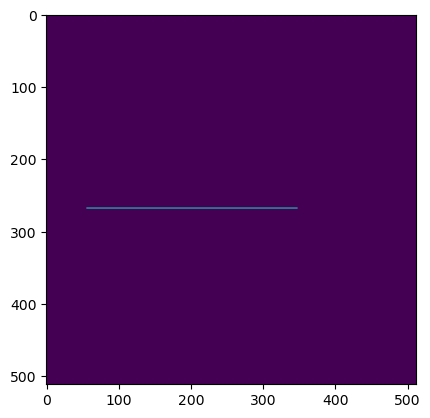

In [211]:
plt.imshow(im_noxovers)

In [212]:
im_props = measure.regionprops_table(im_noxovers, max_im,
                                    properties=['area', 'major_axis_length',
                                                'minor_axis_length','centroid',
                                                'orientation', 'eccentricity',
                                                'label', 'perimeter'])
_df = pd.DataFrame(im_props)

In [213]:
_df

,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,orientation,eccentricity,label,perimeter
0,292,337.17058,0.0,268.0,201.5,1.570796,1.0,1,290.0


In [215]:
max_im[test_line[200], xvals[200]]

2.0

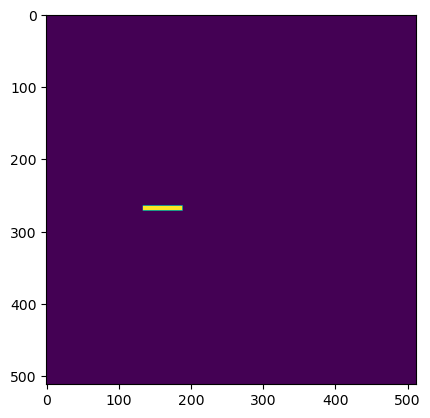

In [216]:
plt.imshow(stack[3])

(10, 338)

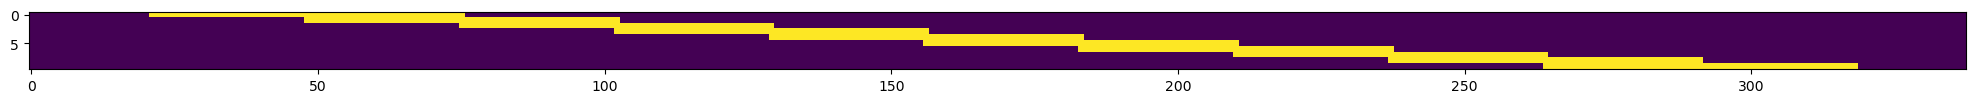

In [218]:
# plt.imshow(max_im[200:300, 0:500])
stack[0][test_line[0]:test_line[-1], xvals[0]:xvals[-1]]
mykymo = []
for im in stack:
    ls=[]
    for i in range(len(xvals)):
        ls.append(im[test_line[i], xvals[i]])
    mykymo.append(ls)
mykymo = np.array(mykymo)
fig,ax=plt.subplots(figsize=(25,8))
plt.imshow(mykymo)
np.shape(mykymo)

4312.047746513252 nm/s


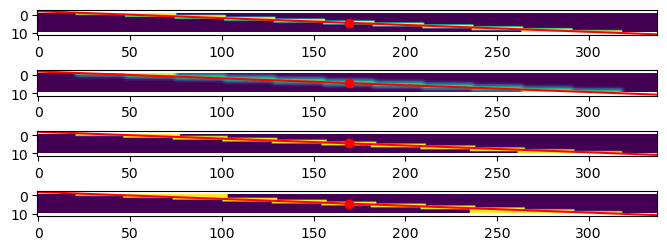

In [222]:
kymo_func(mykymo, sigma = 1, mask_size=3, pixel_size = pixel_size)

In [219]:
np.shape(kymobuild)

(10, 295)

In [182]:
testls==max_im[test_line[0], xvals[0]:xvals[-1]+1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

# Segment Max Proj

In [204]:
#Choose the experiment file name(located in folder 'Asters'):
file_path = '../../data/gliding/'
file_folder = '2023-03-24_Gliding/940/2023-Mar24_AnaGliding_Ncd-cherry-MT488_ATP940_lowATPload_4.5min_1/'
included_frames = 'MAX_2023-Mar24_AnaGliding_Ncd-cherry-MT488_ATP940_lowATPload_4.5min_1_MMStack_Pos0.ome.tif'
im_dir = file_path+file_folder+included_frames
max_proj = skimage.io.imread(im_dir).astype(np.int16)

#camera background
bg_file_path = '../../data/gliding/'
bg_file_folder = '2023-Mar24_CAMERA-OFF_1/'
included_bg_frames = '2023-Mar24_CAMERA-OFF_1_MMStack_Pos0.ome.tif'
bg_im_dir = bg_file_path+bg_file_folder+included_bg_frames
bg = skimage.io.imread(bg_im_dir).astype(np.int16)
bg_avg = np.average(bg)


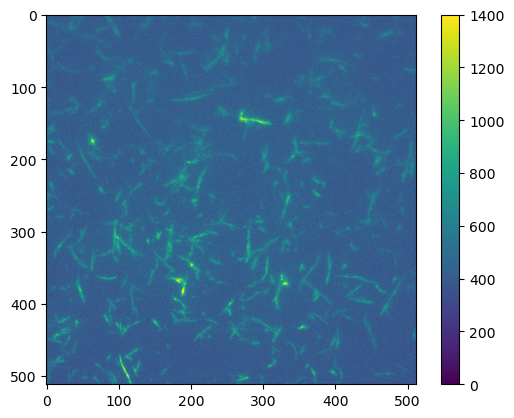

In [205]:
plt.imshow(max_proj, vmin = 0, vmax=1400)
plt.colorbar()

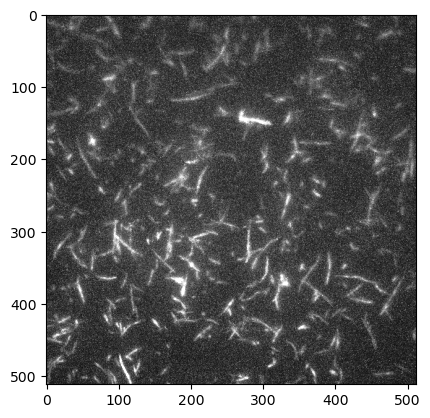

In [207]:
image_norm = (max_proj - max_proj.min()) / (max_proj.max() - max_proj.min())
plt.imshow(image_norm, vmin=0, vmax=0.5, cmap='Greys_r')
#plt.colorbar()

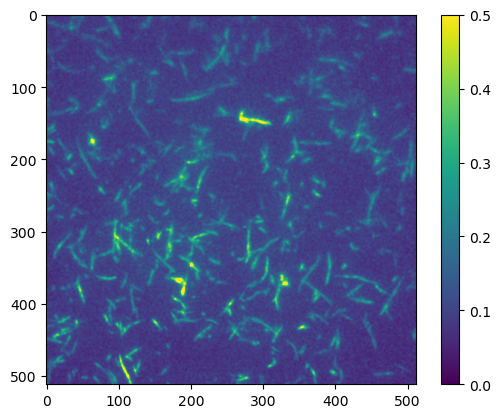

In [98]:
block_size = 3
thresh_niblack = filters.threshold_niblack(image_norm, window_size=block_size, k=0.001)
plt.imshow(thresh_niblack, vmin=0, vmax=0.5)
plt.colorbar()

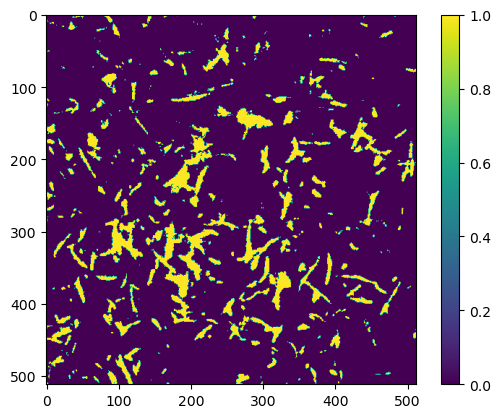

In [99]:
thresh_otsu = filters.threshold_otsu(thresh_niblack)
im_thresh = (thresh_niblack > thresh_otsu)
plt.imshow(im_thresh)
plt.colorbar()

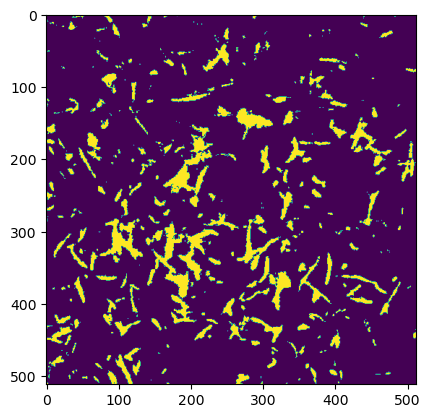

In [100]:
mask_size=1
mask = morphology.square(mask_size)
im_closed = morphology.closing(im_thresh, selem=mask)
plt.imshow(im_closed)

In [101]:
im_filtered = im_closed.copy()

number of regions = 449


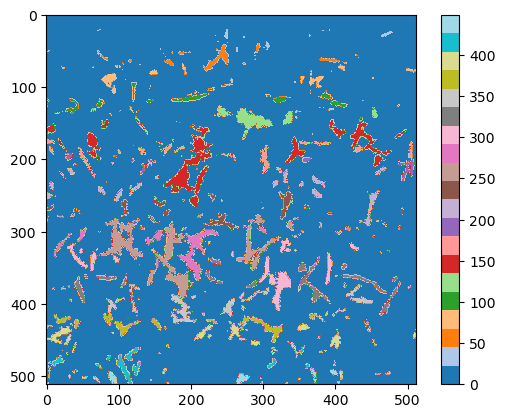

In [102]:
im_label, n_labels = measure.label(im_filtered, return_num=True)
print('number of regions = ' + str(n_labels))
plt.imshow(im_label, cmap = 'tab20')
plt.colorbar();

In [103]:
unique_regions, region_counts = np.unique(im_label, return_counts=True)

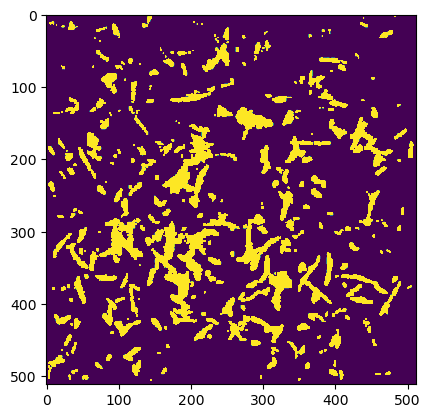

In [105]:
im_border = np.copy(im_label)
edge=3
border = np.ones(np.shape(im_label))
border[edge:-1*edge,edge:-1*edge] -= 1

for n in np.unique(im_border):
    if np.any(border * [im_border==n+1]):
        im_border[im_border==n+1] = 0

im_internal=im_border
plt.imshow(im_border, vmin=0, vmax=1)

In [106]:
# Create dictionary except for 0 (background)
dict_area = dict(zip(unique_regions,region_counts))

#Remove small regions
area_thresh=10
im_sized = np.copy(im_internal)
for label in unique_regions:
    if label > 0 and dict_area[label]<=area_thresh:
        im_sized[im_sized==label] = 0

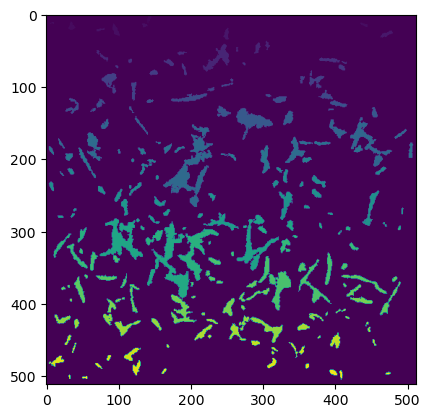

In [107]:
plt.imshow(im_sized)

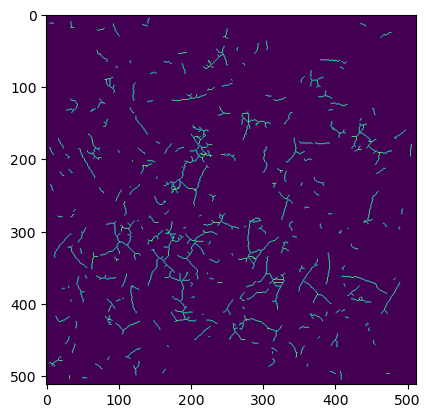

In [108]:
im_thinned = morphology.thin(im_sized)
im_relabel = measure.label(im_thinned)
plt.imshow(im_thinned)

In [109]:
min_dist=9
min_angle=75
padding=3
im_noxovers = remove_line_crossovers(im_relabel, min_dist=min_dist,
                                    min_angle=min_angle, padding=padding)

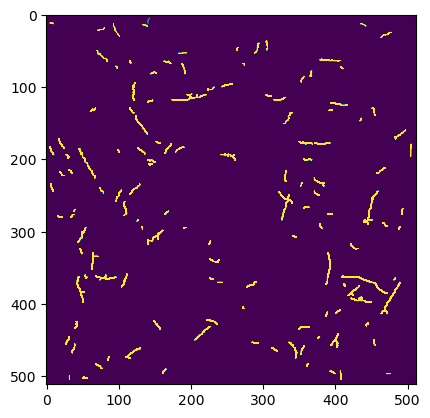

In [110]:
plt.imshow(im_noxovers, vmin=0, vmax = 1)

In [111]:
im_props = measure.regionprops_table(im_noxovers, max_proj,
                                    properties=['area', 'major_axis_length',
                                                'minor_axis_length','centroid',
                                                'orientation', 'eccentricity',
                                                'label', 'perimeter'])
_df = pd.DataFrame(im_props)

In [112]:
_df

,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,orientation,eccentricity,label,perimeter
0,8,9.652881,2.138198,8.500000,141.125000,-0.327676,0.975158,1,7.242641
1,6,6.902545,1.115241,12.166667,7.500000,1.425068,0.986861,3,4.207107
2,18,22.948041,2.109301,21.500000,95.944444,0.443006,0.995767,4,19.106602
3,8,10.026790,1.101585,14.125000,438.500000,1.150496,0.993947,5,7.035534
4,8,9.536478,1.027419,15.000000,136.500000,1.289138,0.994180,6,6.828427
...,...,...,...,...,...,...,...,...,...
127,8,10.119406,1.160873,495.375000,396.500000,1.129917,0.993398,207,7.242641
128,12,13.870023,1.135399,499.500000,407.750000,0.094764,0.996644,208,10.414214
129,5,5.656854,0.000000,497.000000,473.000000,1.570796,1.000000,209,3.000000
130,5,5.656854,0.000000,502.000000,32.000000,0.000000,1.000000,210,3.000000


array([-15.        , -13.96551724, -12.93103448, -11.89655172,
       -10.86206897,  -9.82758621,  -8.79310345,  -7.75862069,
        -6.72413793,  -5.68965517,  -4.65517241,  -3.62068966,
        -2.5862069 ,  -1.55172414,  -0.51724138,   0.51724138,
         1.55172414,   2.5862069 ,   3.62068966,   4.65517241,
         5.68965517,   6.72413793,   7.75862069,   8.79310345,
         9.82758621,  10.86206897,  11.89655172,  12.93103448,
        13.96551724,  15.        ])

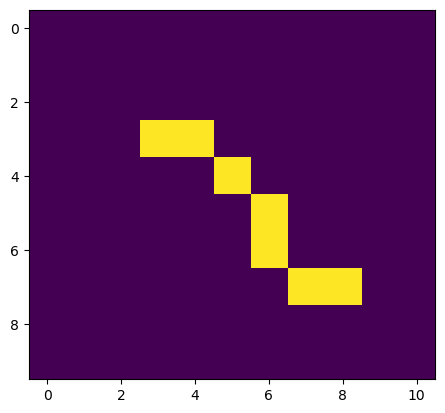

In [149]:
x,y = np.where(im_relabel==125)
mt_segment = im_relabel[x.min()-padding:x.max()+padding,y.min()-padding:y.max()+padding]
plt.imshow(mt_segment)

min_dist=9
min_angle=75
padding=3

test_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
h, theta, d = transform.hough_line(mt_segment, theta=test_angles)

_, angles, _ = transform.hough_line_peaks(h, theta, d, 
                                          min_distance=min_dist,
                                          min_angle=min_angle, 
                                          num_peaks=2)  
# im_cleaned = max_proj.copy()

# for n in np.unique(max_proj)[1:]:
#     x,y = np.where(max_proj==n)
#     mt_segment = max_proj[x.min()-padding:x.max()+padding,y.min()-padding:y.max()+padding]

#     if are2lines(mt_segment, min_dist=min_dist, min_angle=min_angle):
#         im_cleaned = np.where(im_cleaned==n, 0, im_cleaned)

In [93]:
np.unique(im_eccen)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [107]:
im_eccen = im_label.copy()
im_props = measure.regionprops_table(im_eccen, properties=['label','eccentricity'])
df = pd.DataFrame(im_props)

eccen_thresh=0.90
for n in np.unique(im_eccen)[1:]:
    if df.loc[n-1, 'eccentricity'] < eccen_thresh:
        im_eccen[im_eccen==n] = 0

In [108]:
df[df['label']==n]['eccentricity'].values

array([0.81649658])

In [109]:
df.loc[n-1, 'eccentricity']

0.816496580927726

In [110]:
len(np.unique(im_eccen))

180

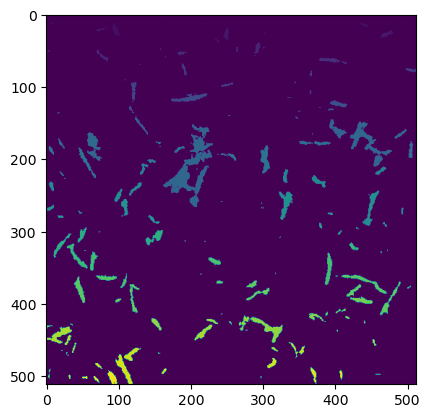

In [111]:
plt.imshow(im_eccen)

In [ ]:
x,y = np.where(max_proj==n)
mt_segment = max_proj[x.min()-padding:x.max()+padding,y.min()-padding:y.max()+padding]

In [114]:
test_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
    h, theta, d = transform.hough_line(mt_segment, theta=test_angles)

    _, angles, _ = transform.hough_line_peaks(h, theta, d, 
                                                min_distance=min_dist,
                                                min_angle=min_angle,
                                                num_peaks=2)   

(512, 512)

In [ ]:
test_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
    h, theta, d = transform.hough_line(mt_segment, theta=test_angles)

    _, angles, _ = transform.hough_line_peaks(h, theta, d, 
                                                min_distance=min_dist,
                                                min_angle=min_angle,
                                                num_peaks=2)

In [113]:
min_dist=9
min_angle=75
padding=3

im_cleaned = max_proj.copy()

for n in np.unique(max_proj)[1:]:
    x,y = np.where(max_proj==n)
    mt_segment = max_proj[x.min()-padding:x.max()+padding,y.min()-padding:y.max()+padding]

    if are2lines(mt_segment, min_dist=min_dist, min_angle=min_angle):
        im_cleaned = np.where(im_cleaned==n, 0, im_cleaned)

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
plt.imwho(im_cleaned)

In [38]:
np.sum(_), np.shape(max_proj)[0]**2

(262144, 262144)

In [39]:
count_thresh=200
unique[-1] > count_thresh

True

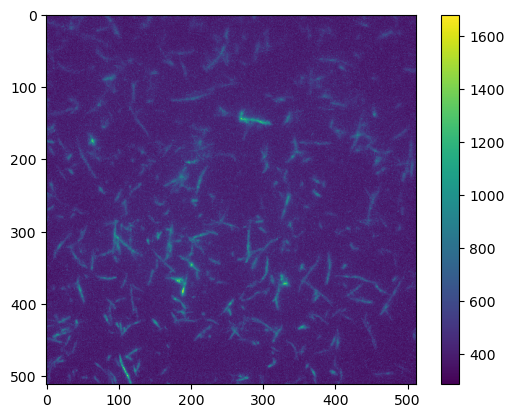

In [40]:
im_subt = max_proj - im_closed
plt.imshow(im_subt)
plt.colorbar()

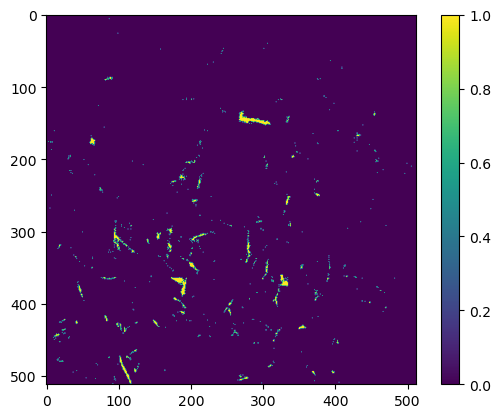

In [41]:
im_yen = filters.threshold_yen(im_subt)
im_filtered_yen = im_subt > im_yen
plt.imshow(im_filtered_yen)
plt.colorbar()

In [128]:
def filter_mts(image, block_size=5, mask_size=5, yen=False):
    """
    Image processing for individual MT image file. Images are first normalized
    before applying local thresholding to correct for nonuniform image background.
    Global thresholding is then performed to obtain the thresholded image of
    putative microtubules. Further processing is performed where small breaks
    in filaments are reconnected again.
    """
    image_norm = (image - image.min()) / (image.max() - image.min())

    thresh_niblack = filters.threshold_niblack(image_norm, window_size=block_size,
                                                k=0.001)

    # Rather than applying the threshold to the image to create a binary
    # image, the threshold array thresh_niblack thickens the MTs, reducing
    # filament break-up. This is used then in the Otsu thresholding to
    # produce the binary image.
    thresh_otsu = filters.threshold_otsu(thresh_niblack)
    im_thresh = (thresh_niblack > thresh_otsu)

    mask = morphology.square(mask_size)
    im_closed = morphology.closing(im_thresh, selem=mask)

    if yen==True:
        im_subt = image - im_closed
        im_yen = filters.threshold_yen(im_subt)
        im_filtered = im_subt > im_yen
    else:
        im_filtered = im_closed.copy()

    return im_filtered

def border_clear(im_label, edge=3):
    """
    Remove objects within `edge` pixels from the image boundary

    Input
    -------
    im_label : labeled image where objects in the image are assigned positive integer value
    edge : maximum number of pixels that putative filament needs to be away from the image boundary to be rejected
    """
    im_border = np.copy(im_label)

    border = np.ones(np.shape(im_label))
    border[edge:-1*edge,edge:-1*edge] -= 1

    for n in np.unique(im_border):
        if np.any(border * [im_border==n+1]):
            im_border[im_border==n+1] = 0

    return im_border

def determine_count_nums(im_label):
    """
    Obtains maximum number of objects in the labeled image. Used to determine
    if background subtraction and thresholding must be performed on top of Niblack
    thresholding scheme.
    """
    unique, counts = np.unique(im_label, return_counts=True)

    return unique, counts

def remove_small(im_label, area_thresh=10):
    im_sized = np.copy(im_label)

    unique, counts = determine_count_nums(im_label)

    # Create dictionary except for 0 (background)
    dict_area = dict(zip(unique,counts))

    for label in unique:
        if label > 0 and dict_area[label]<=area_thresh:
            im_sized[im_sized==label] = 0
    
    return im_sized

def remove_circulars(im_label, eccen_thresh=0.8):
    im_eccen = im_label.copy()

    im_props = measure.regionprops_table(im_eccen,
                                        properties=['label','eccentricity'])
    df = pd.DataFrame(im_props)

    for n in np.unique(im_eccen):
        if df[df['label']==n]['eccentricity'].values < eccen_thresh:
            im_eccen[im_eccen==n] = 0

    return im_eccen

def are2lines(mt_segment, min_dist=9, min_angle=75):
    """
    Determine if putative microtubules are two microtubules. Uses
    Hough straight lines to determine if there are at least 2
    lines that can be drawn from the putative filament.
    
    Input
    -------
    mt_segment : (M, N), ndarray; cropped region about the putative
                 microtubule
    min_angle : int, minimum angle (in degrees) separating lines (default 75)
    
    Return
    -------
    len(angles)==2 : bool, determines whether there is a crossover
    """
    test_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
    h, theta, d = transform.hough_line(mt_segment, theta=test_angles)

    _, angles, _ = transform.hough_line_peaks(h, theta, d, 
                                                min_distance=min_dist,
                                                min_angle=min_angle,
                                                num_peaks=2)

    return len(angles)==2

def remove_line_crossovers(image, min_dist=9, min_angle=75, padding=3):
    """
    Removes microtubules that cross over in the images. 
    Input
    -------
    image : (M, N), ndarray; image from which MT crossovers are removed
    min_angle : int, minimum angle (in degrees) separating lines (default 30)
    padding : int, padding around cropped MT segments

    Return
    -------
    im_cleaned : (M, N), ndarray; image with MT crossovers removed
    """
    im_cleaned = image.copy()

    for n in np.unique(image)[1:]:
        x,y = np.where(image==n)
        mt_segment = image[x.min()-padding:x.max()+padding,y.min()-padding:y.max()+padding]
        
        if are2lines(mt_segment, min_dist=min_dist, min_angle=min_angle):
            im_cleaned = np.where(im_cleaned==n, 0, im_cleaned)

    return im_cleaned

def process_mt_images(image, block_size=3, mask_size=3, count_thresh=200, edge=3, area_thresh=10, min_dist=9, min_angle=75, padding=3):
    im_filtered = filter_mts(image, block_size=block_size, mask_size=mask_size)
    im_label, n_labels = measure.label(im_filtered, return_num=True)
    # Determine if Yen thresholding background subtraction is necessary
    unique, _ = determine_count_nums(im_label)
    if unique[-1] > count_thresh:
        im_filtered = filter_mts(image, block_size=block_size, mask_size=mask_size, yen=True)
        im_label, n_labels = measure.label(im_filtered, return_num=True)
    im_internal = border_clear(im_label, edge=edge)
    im_sized = remove_small(im_internal, area_thresh=area_thresh)
    im_thinned = morphology.thin(im_sized)
    im_relabel = measure.label(im_thinned)
    im_noxovers = remove_line_crossovers(im_relabel, min_dist=min_dist,
                                        min_angle=min_angle, padding=padding)

    return im_noxovers

In [116]:
def maj_ax_eqn(array, xc, yc, l, theta):
    return np.tan(theta)*array + yc - 0.5*l*np.sin(theta)

In [134]:
df = _df[_df['area']==np.max(_df['area'])]

In [212]:
xvals = np.arange(0, np.shape(kymo)[1])
index = 31
xc =  _df.loc[index, 'centroid-1']
yc =  _df.loc[index, 'centroid-0']
l =  _df.loc[index, 'major_axis_length']
theta = -_df.loc[index, 'orientation'] + (np.pi/2)

test_line = np.tan(theta)*xvals + yc + 0.5*l*np.sin(theta)

-0.07068440424563083

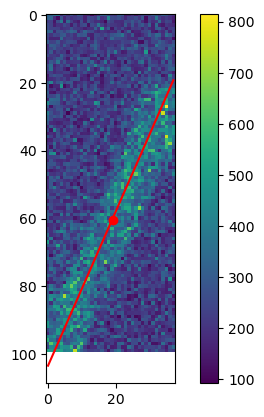

In [219]:
plt.imshow(kymo)
plt.colorbar()
plt.plot(xvals, test_line, color = 'r')
plt.scatter(xc, yc, color = 'r')

x1 = xc + np.cos(theta) * 0.5 * _df.loc[1, 'minor_axis_length']
y1 = yc - np.sin(theta) * 0.5 * _df.loc[1, 'minor_axis_length']
x2 = xc - np.sin(theta) * 0.5 * l
y2 = yc - np.cos(theta) * 0.5 * l
pixel_size / np.tan(theta)
# plt.plot((xc, x1), (yc, y1), 'w', linewidth=2.5)
# plt.plot((xc, x2), (yc, y2), 'k', linewidth=2.5)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


(<Figure size 800x500 with 8 Axes>,
 array([<AxesSubplot:title={'center':'Original'}>,
        <AxesSubplot:title={'center':'Isodata'}>,
        <AxesSubplot:title={'center':'Li'}>,
        <AxesSubplot:title={'center':'Mean'}>,
        <AxesSubplot:title={'center':'Minimum'}>,
        <AxesSubplot:title={'center':'Otsu'}>,
        <AxesSubplot:title={'center':'Triangle'}>,
        <AxesSubplot:title={'center':'Yen'}>], dtype=object))

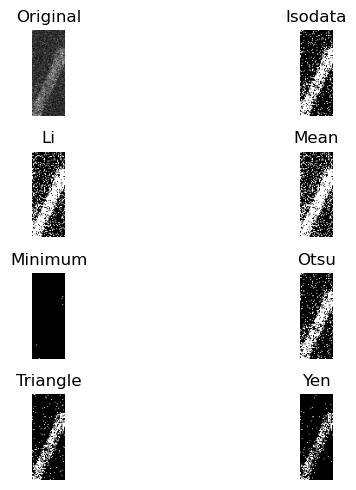

In [44]:
sf.try_all_threshold(kymo-bg_avg)

In [ ]:
def filter_mts(image, block_size=5, mask_size=5, yen=False):
    """
    Image processing for individual MT image file. Images are first normalized
    before applying local thresholding to correct for nonuniform image background.
    Global thresholding is then performed to obtain the thresholded image of
    putative microtubules. Further processing is performed where small breaks
    in filaments are reconnected again.
    """
    image_norm = (image - image.min()) / (image.max() - image.min())

    thresh_niblack = filters.threshold_niblack(image_norm, window_size=block_size,
                                                k=0.001)

    # Rather than applying the threshold to the image to create a binary
    # image, the threshold array thresh_niblack thickens the MTs, reducing
    # filament break-up. This is used then in the Otsu thresholding to
    # produce the binary image.
    thresh_otsu = filters.threshold_otsu(thresh_niblack)
    im_thresh = (thresh_niblack > thresh_otsu)

    mask = morphology.square(mask_size)
    im_closed = morphology.closing(im_thresh, selem=mask)

    if yen==True:
        im_subt = image - im_closed
        im_yen = filters.threshold_yen(im_subt)
        im_filtered = im_subt > im_yen
    else:
        im_filtered = im_closed.copy()

    return im_filtered